### **Comparison NRFA versus Era5 Precipitation Data**

*_Author: Aline Van Driessche_*

This notebook contains all code needed accompanying the discussion on the comparison of performance between NN trainings performed on the Era5 and NRFA Precipitation data. The precipitation input variables for both models are obtained by following the instructions in the 'README' and subsequently running 'assembly.py'. The model outputs used here are obtained by running the 'ANN_replication.ipynb' notebook (experiment 3) when using the parameter input_type *'9to9_linear'* and *'9to9_nrfa'* respectively. 

#### Setup

Importing relevant modules and custom scripts. A number of helper functions are also defined to clean up experiment code.

In [140]:
import os
import paths

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import ttest_ind
from train_model import load_data
from preprocessing import visualisation
from preprocessing import catchment_characteristics as cc

import matplotlib.dates as mdt

In [160]:
def plot_biases_all_years_log_transform_boxplot(high_bias_all, mid_bias_all, low_bias_all, years, save_path=None):
    # Combine data for all regimes into a single DataFrame
    data = []
    for year in years:
        for df, regime in zip([high_bias_all, mid_bias_all, low_bias_all], ['High', 'Mid', 'Low']):
            for sub_df in df:
                df_year = sub_df[sub_df['Date'].dt.year == year]
                df_year['Month'] = df_year['Date'].dt.strftime('%b')
                df_year['Regime'] = regime
                df_year['LogError'] = np.log1p(df_year['Error'])  # Apply log transformation
                data.append(df_year)
    
    combined_data = pd.concat(data)
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 6))
    
    sns.stripplot(x='Month', y='LogError', hue='Regime', data=combined_data,
                  hue_order=['High', 'Mid', 'Low'], palette=['#FFD700', '#FF4500', '#008080'],
                  dodge=True, size=1, jitter=True, alpha=0.5, marker='o', zorder=1)
    sns.boxplot(x='Month', y='LogError', hue='Regime', data=combined_data,
                hue_order=['High', 'Mid', 'Low'], palette=['#FFD700', '#FF4500', '#008080'],
                width=0.75, linewidth=1, whis=(0, 100), zorder=2)

    plt.ylabel('Log of Data Bias', fontweight='bold', fontsize=12)
    plt.xlabel('Month', fontweight='bold', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    ax = plt.gca()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    plt.tick_params(axis='both', labelsize=12)

    # Adjust legend
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles[-3:], ['High regime: > 75% quantile', 'Mid regime: interquartile', 'Low regime: < 25% quantile'], fontsize='12', loc='upper right')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

    # Customize axis spines
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [147]:
# Function to plot biases for a selected year
def plot_biases_all_years(high_bias_all, mid_bias_all, low_bias_all, years, save_path):
    plt.figure(figsize=(14, 6))
    
    for year in years:
    
        # Plot high regime bias
        for df in high_bias_all:
            df_year = df[df['Date'].dt.year == year]
            df_year.loc[:, 'MonthDay'] = df_year['Date'].apply(lambda date: date.strftime('%m-%d'))
            plt.scatter(df_year['MonthDay'], df_year['Error'], color='darkKhaki', label='High Regime Bias (75% quantile)', s=2)
    
        # Plot mid regime bias
        for df in mid_bias_all:
            df_year = df[df['Date'].dt.year == year]
            df_year.loc[:, 'MonthDay'] = df_year['Date'].apply(lambda date: date.strftime('%m-%d'))
            plt.scatter(df_year['MonthDay'], df_year['Error'], color='orangered', label='Mid Regime Bias (25-75% quantile)', s=2)
    
        # Plot low regime bias
        for df in low_bias_all:
            df_year = df[df['Date'].dt.year == year]
            df_year.loc[:, 'MonthDay'] = df_year['Date'].apply(lambda date: date.strftime('%m-%d'))
            plt.scatter(df_year['MonthDay'], df_year['Error'], color='Teal', label='Low Regime Bias (25% quantile)', s=2)

    #plt.xlabel('Date')
    plt.ylabel('Data Bias')
    plt.ylim(0,40)
    sns.set(style="whitegrid")
    
    plt.annotate('log(2) ≈ 0.69', xy=(0, np.log1p(1)), xytext=(0, np.log1p(1)+0.5),
                arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('log(3) ≈ 1.10', xy=(0, np.log1p(2)), xytext=(0, np.log1p(2)+0.5),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Format the x-axis to show months
    plt.gca().xaxis.set_major_locator(mdt.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

### 1. Comparing the precipitation inputs

This section recreates the graphs comparing the input precipitation variables for both Era5 and NRFA data. Firstly, it maps a precipitation plot for a certain year and certain catchment for Era5 as well as the NRFA precipitation. Additionally, it calculates the bias per regime (over all years and all catchments) and plots them together.

In [121]:
station_nr = 7001

rf_9to9_nrfa = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
rf_9to9_linear = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)

rf_9to9_nrfa['Date'] = pd.to_datetime(rf_9to9_nrfa['Date'], format='%Y-%m-%d')
rf_9to9_linear['Date'] = pd.to_datetime(rf_9to9_linear['Date'], format='%Y-%m-%d')

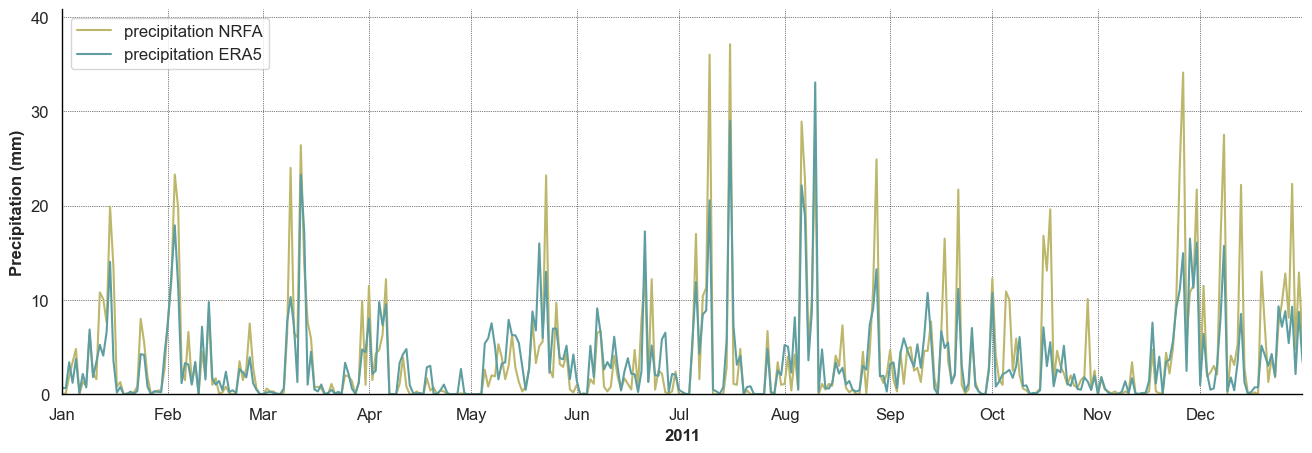

In [122]:
visualisation.compare_precipitation_and_flow(year = 2011,
                                             dfs_precipitation=[rf_9to9_nrfa, rf_9to9_linear], 
                                             colors=['darkKhaki', 'cadetblue'],
                                             labels=[ 'NRFA', 'ERA5'],
                                             save_path=f"{paths.IMAGES}/NRFA_vs_Era5_{station_nr}.png")

In [58]:
mean_bias_high_list = []
mean_bias_mid_list = []
mean_bias_low_list = []
t_stats = []
p_values = []

high_bias_all = []
mid_bias_all = []
low_bias_all = []

for station_nr in tqdm(os.listdir('../' + paths.CATCHMENT_BASINS), desc="Processing Stations"):

    # Load the data 
    rf_9to9_nrfa = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
    rf_9to9_linear = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)

    rf_9to9_nrfa['Date'] = pd.to_datetime(rf_9to9_nrfa['Date'], format='%Y-%m-%d')
    rf_9to9_linear['Date'] = pd.to_datetime(rf_9to9_linear['Date'], format='%Y-%m-%d')

    # Calculate bias
    df_comparison = rf_9to9_nrfa[['Date', 'Rain']].merge(rf_9to9_linear[['Date', 'Rain']], on='Date')
    df_comparison = df_comparison.rename(columns={'Rain_x':'Observation', 'Rain_y':'Reanalysis'})
    df_comparison['Error'] = abs(df_comparison['Observation'] - df_comparison['Reanalysis'])

    # Define thresholds for high and low regimes
    threshold_high = df_comparison['Observation'].quantile(0.75).mean()  # 75th percentile as an example
    threshold_low = df_comparison['Observation'].quantile(0.25).mean()   # 25th percentile as an example

    # Categorize into high and low regimes
    high_regime_bias = df_comparison[['Date', 'Error']][df_comparison['Observation'] >= threshold_high]
    mid_regime_bias = df_comparison[['Date', 'Error']][(df_comparison['Observation'] > threshold_low) & (df_comparison['Observation'] < threshold_high)]
    low_regime_bias = df_comparison[['Date', 'Error']][df_comparison['Observation'] <= threshold_low]

    # Calculate mean bias for each regime
    mean_bias_high = high_regime_bias['Error'].mean()
    mean_bias_mid = mid_regime_bias['Error'].mean()
    mean_bias_low = low_regime_bias['Error'].mean()
    
    high_bias_all.append(high_regime_bias)
    mid_bias_all.append(mid_regime_bias)
    low_bias_all.append(low_regime_bias)
    
    # Store the results
    mean_bias_high_list.append(mean_bias_high)
    mean_bias_mid_list.append(mean_bias_mid)
    mean_bias_low_list.append(mean_bias_low)

    # Flatten the DataFrames to 1D arrays for t-test
    high_bias_values = high_regime_bias['Error'].values.flatten()
    mid_bias_values = mid_regime_bias['Error'].values.flatten()
    low_bias_values = low_regime_bias['Error'].values.flatten()
    t_stat, p_value = ttest_ind(high_bias_values, low_bias_values, nan_policy='omit')

    t_stats.append(t_stat)
    p_values.append(p_value)

# Summarize results across all catchments
mean_bias_high_overall = np.mean(mean_bias_high_list)
mean_bias_mid_overall = np.mean(mean_bias_mid_list)
mean_bias_low_overall = np.mean(mean_bias_low_list)
t_stat_overall = np.mean(t_stats)
p_value_overall = np.mean(p_values)

print("Overall Mean Bias in High Regime across all catchments:", mean_bias_high_overall)
print("Overall Mean Bias in Mid Regime across all catchments:", mean_bias_mid_overall)
print("Overall Mean Bias in Low Regime across all catchments:", mean_bias_low_overall)
print(f"Overall T-statistic: {t_stat_overall}, Overall P-value: {p_value_overall}")

#plot_biases_all_years(high_bias_all, mid_bias_all, low_bias_all, [1981 + i for i in range(40)], save_path=f"{paths.IMAGES}/bias_NRFA_vs_Era5.png")

Processing Stations: 100%|██████████| 26/26 [00:35<00:00,  1.37s/it]

Overall Mean Bias in High Regime across all catchments: 3.784842981691194
Overall Mean Bias in Mid Regime across all catchments: 1.0192806958097056
Overall Mean Bias in Low Regime across all catchments: 0.2193737671312593
Overall T-statistic: 62.35166291058876, Overall P-value: 0.0


C:\Users\aline\AppData\Local\Temp\ipykernel_30904\1733244651.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Month'] = df_year['Date'].dt.strftime('%b')
C:\Users\aline\AppData\Local\Temp\ipykernel_30904\1733244651.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['Regime'] = regime
C:\Users\aline\AppData\Local\Temp\ipykernel_30904\1733244651.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

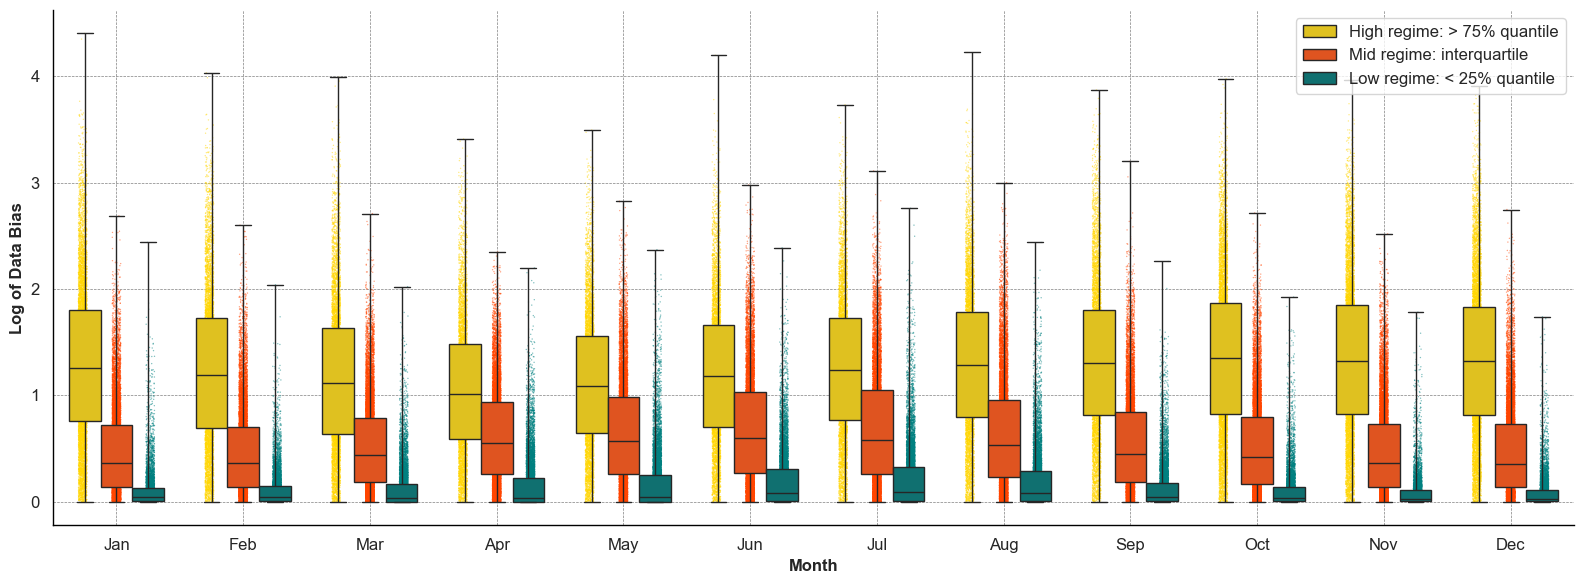

In [161]:
plot_biases_all_years_log_transform_boxplot(high_bias_all, mid_bias_all, low_bias_all, [1981 + i for i in range(40)], 
                      save_path=f"{paths.IMAGES}/boxplot_bias_NRFA_vs_Era5.png")

### 2. Comparing the model performances

This section recreates the graphs comparing the model performances when using Era5 data versus NRFA precipitation values. 

In [152]:
overview_era5_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_linear')
overview_era5_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_linear_Snow')
overview_nrfa_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_nrfa')
overview_nrfa_snow_gdf = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS, 
                                                   input_type='9to9_nrfa_Snow')

comparison = overview_era5_gdf.merge(overview_nrfa_gdf[['Station', 'NSE']], on='Station')
comparison = comparison.rename(columns={'NSE_x':'NSE_Era5', 'NSE_y':'NSE_NRFA'})

comparison_snow = overview_era5_snow_gdf.merge(overview_nrfa_snow_gdf[['Station', 'NSE']], on='Station')
comparison_snow = comparison_snow.rename(columns={'NSE_x':'NSE_Era5_snow', 'NSE_y':'NSE_NRFA_snow'})

comparison = comparison_snow.merge(comparison[['Station', 'NSE_Era5', 'NSE_NRFA']], on='Station')

comparison['model_difference'] = comparison['NSE_NRFA'] - comparison['NSE_Era5']
#comparison[['Station', 'NSE_NRFA', 'NSE_Era5', 'NSE_NRFA_snow', 'NSE_Era5_snow']]

C:\Users\aline\AppData\Local\Temp\ipykernel_30904\2894257689.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(latitude_labels, rotation=45, fontsize=12)


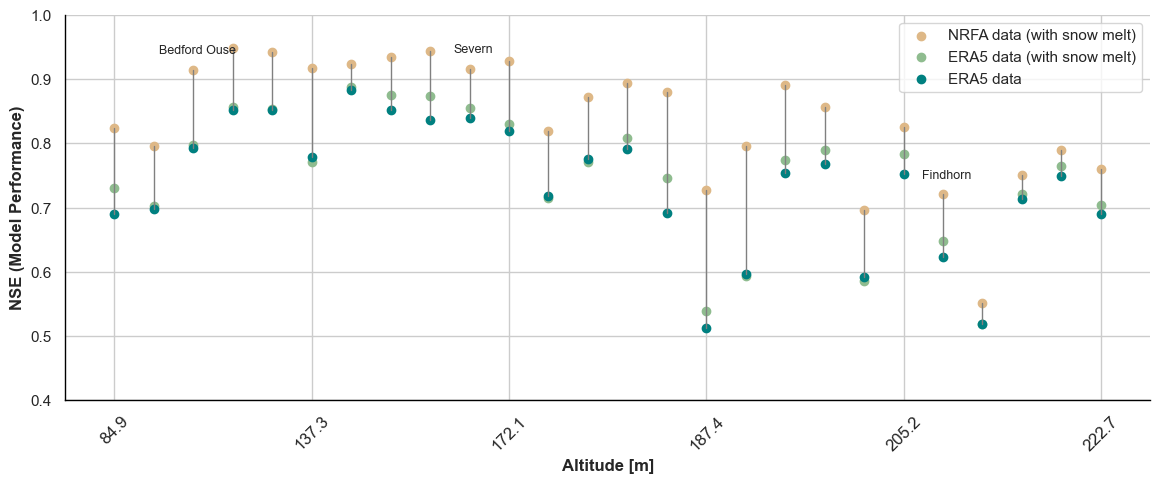

In [157]:
# Sort Dataframe by latitude
sort_param = '90 percentile'
comparison = comparison.sort_values(by=sort_param).reset_index(drop=True)
latitude_labels = [round(value, 2) for value in comparison[sort_param]]

catchment_dict ={'7001':'Findhorn',
                 '33039':'Bedford Ouse',
                 '54057':'Severn'}

fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot NSE values for Era5 and NRFA as dots
ax1.scatter(comparison.index, comparison['NSE_NRFA_snow'], color='BurlyWood', label='NRFA data (with snow melt)')
ax1.scatter(comparison.index, comparison['NSE_Era5_snow'], color='darkseagreen', label='ERA5 data (with snow melt)')
ax1.scatter(comparison.index, comparison['NSE_Era5'], color='Teal', label='ERA5 data')

# Draw lines between each pair of dots
for i in range(len(comparison)):
    ax1.plot([i, i], [comparison['NSE_Era5'].iloc[i], comparison['NSE_NRFA_snow'].iloc[i]], color='gray', linestyle='-', linewidth=1)
    
# Add station names next to the focus catchments
param = 'NSE_NRFA_snow'
for j, row in comparison.iterrows():
    if row['Station'] in ['7001','33039','54057']:
        x_offset = 0.1
        y_offset = 0.025
        ax1.text(j + x_offset, row[param] + y_offset, catchment_dict.get(row['Station']), fontsize=9, ha='center')

# Labels and title for the first axis
ax1.set_xlabel('Altitude [m]', fontweight='bold', fontsize=12)
ax1.set_ylabel('NSE')
ax1.set_xticklabels(latitude_labels, rotation=45, fontsize=12)
ax1.set_ylim(0.4,1)
ax1.set_ylabel('NSE (Model Performance)', fontweight='bold', fontsize=12)
ax1.legend(loc='upper right')

ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')

plt.grid(True)
plt.savefig(f"{paths.IMAGES}/nrfa_vs_era5_modelperformance.png", dpi=300, bbox_inches='tight')
plt.show()

#### 3. Mapping the Normalised Error between NRFA and Era5 precipitation data per catchment compared to the catchment characteristics

In [ ]:
df_error = []
for station_nr in os.listdir(['../' + paths.CATCHMENT_BASINS]):
    rf_9to9_nrfa = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
    rf_9to9_linear = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)

    rf_9to9_nrfa['Date'] = pd.to_datetime(rf_9to9_nrfa['Date'], format='%Y-%m-%d')
    rf_9to9_linear['Date'] = pd.to_datetime(rf_9to9_linear['Date'], format='%Y-%m-%d')
    
    df_comparison = rf_9to9_nrfa[['Date', 'Rain']].merge(rf_9to9_linear[['Date', 'Rain']], on='Date')
    df_comparison = df_comparison.rename(columns={'Rain_x':'Observation', 'Rain_y':'Reanalysis'})
    df_comparison = df_comparison.dropna()
    
    NSE_error = me.R2(df_comparison['Observation'], df_comparison['Reanalysis'])
    
    df_error.append([station_nr, NSE_error])
    
df_errors= pd.DataFrame(df_error, columns=['Station', 'NSE_error'])

characteristics_df = cc.get_characteristics_all_stations('../' + paths.CATCHMENT_BASINS)
total_df = characteristics_df.merge(df_errors, on='Station')
total_df

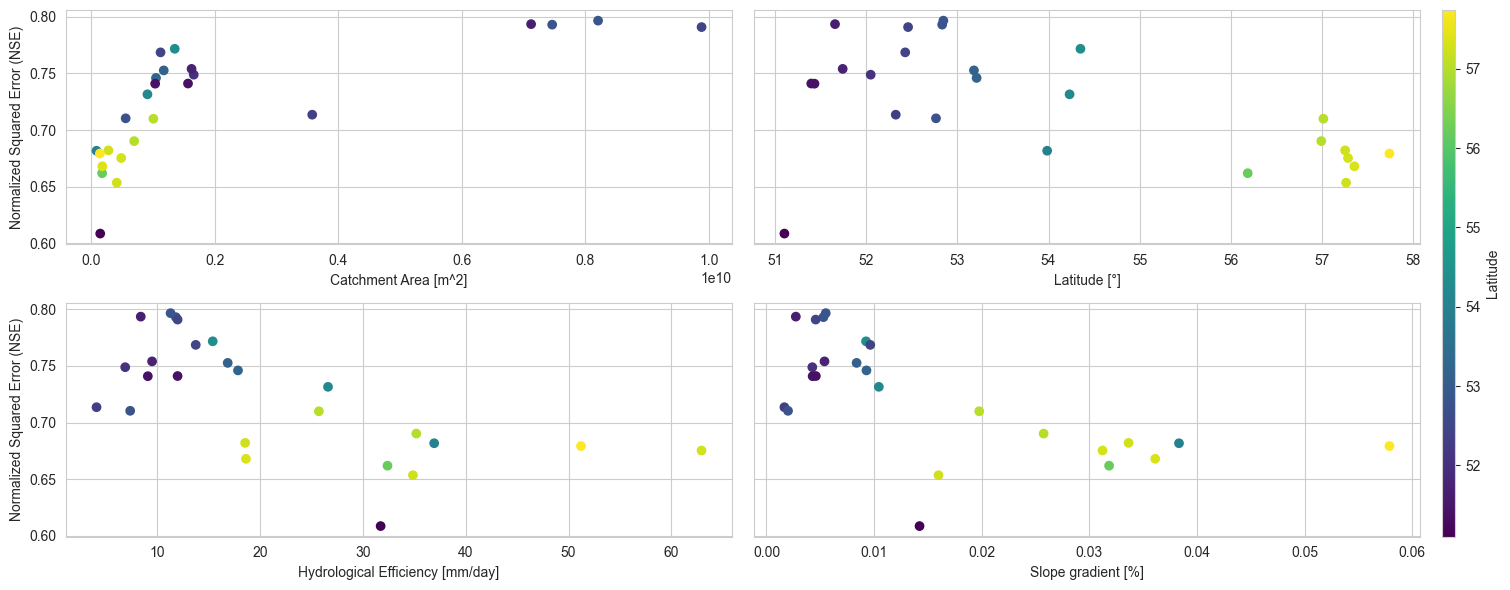

In [214]:
from matplotlib import gridspec

params_to_plot = ['Area', 'Latitude', 'HE_mean', 'Slope gradient']
labels_to_plot = ['Catchment Area [m^2]', 'Latitude [°]', 'Hydrological Efficiency [mm/day]', 'Slope gradient [%]']

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.02])
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(total_df['Latitude'].min(), total_df['Latitude'].max())

# Plot each parameter in its respective subplot
for i, param in enumerate(params_to_plot):
    if i < 4:
        sc = axes[i].scatter(total_df[param], total_df['NSE_error'], c=total_df['Latitude'], cmap=cmap, norm=norm, marker='o')
        axes[i].set_xlabel(labels_to_plot[i])
        if i == 0 or i == 2:
            axes[i].set_ylabel('Normalized Squared Error (NSE)')
        else:
            axes[i].set_yticklabels([])
        
        # Add station names next to each dot
        #for j, row in overview_gdf.iterrows():
            #axes[i].text(row[param], row['NSE'], row['Station'], fontsize=8, ha='left')
        
        axes[i].grid(True)

# Add colorbar to indicate latitude
cax = fig.add_subplot(gs[:, 2]) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation='vertical', label='Latitude')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.savefig(f"{paths.IMAGES}/nrfa_vs_era5.png", dpi=300, bbox_inches='tight')
plt.show()